In [9]:
import os
import sys
import glob
import math
from pathlib import Path

import seaborn as sns
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
torch.backends.cudnn.benchmark = True

from fastsnn import results

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
root = Path(os.path.abspath("")).parent

In [12]:
benchmark_query = results.Benchmark2dQuery(os.path.join(root, "results/benchmarks/2d"))
benchmark_units_query = results.BenchmarkUnitsQuery(os.path.join(root, "results/benchmarks/units"))
benchmark_layers_query = results.BenchmarkLayersQuery(os.path.join(root, "results/benchmarks/layers"))

palette = [sns.color_palette("light:b", as_cmap=False)[i] for i in [1, 3, 5]]

In [14]:
beta_requires_grad = True

# 1. Robust speedup

## 2D speedup plot

In [15]:
class MidpointNormalize(matplotlib.colors.Normalize):
    
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        super().__init__(vmin, vmax, clip)
    
    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [16]:
def plot_contour(ax, x, y, z, z_min, z_max, fontscale=1, ylabel=None, title="", s=3):
    title_size = int(fontscale * 20)
    labelsize = int(fontscale * 20)
    ticksize = int(fontscale * 14)
    tickpad = int(fontscale * 10)
    labelpad = int(fontscale * 16)
    titlepad = int(fontscale * 15)
    edge_width = 0
    
    colorbar = ax.tricontourf(x, y, z, levels=np.linspace(z_min, z_max, 100), cmap=plt.cm.RdBu, norm=MidpointNormalize(midpoint=0))
    ax.scatter(x, y, c="gray", s=s)
    
    ax.spines["bottom"].set_linewidth(edge_width)
    ax.spines["top"].set_linewidth(edge_width)
    ax.spines["left"].set_linewidth(edge_width)
    ax.spines["right"].set_linewidth(edge_width)
    ax.xaxis.set_tick_params(width=edge_width)
    ax.yaxis.set_tick_params(width=edge_width)
    
    x_labels = [f"{int(v)}" for v in pd.Series(x).unique()]
    ax.set_yticks(list(pd.Series(y).unique()))
    ax.set_xticks(list(pd.Series(x).unique()))
    ax.set_xticklabels(x_labels)
    
    y_labels = [f"${v}$" for v in pd.Series(y).unique()]
    ax.set_yticklabels(y_labels)
    
    ax.tick_params(axis='both', which='major', labelsize=ticksize, pad=tickpad)
    
    # Title
    ax.set_title(title, fontsize=title_size, pad=titlepad)
    
    return colorbar

acc_z_min -1.2104901803863486
acc_z_max 4.108999088991827


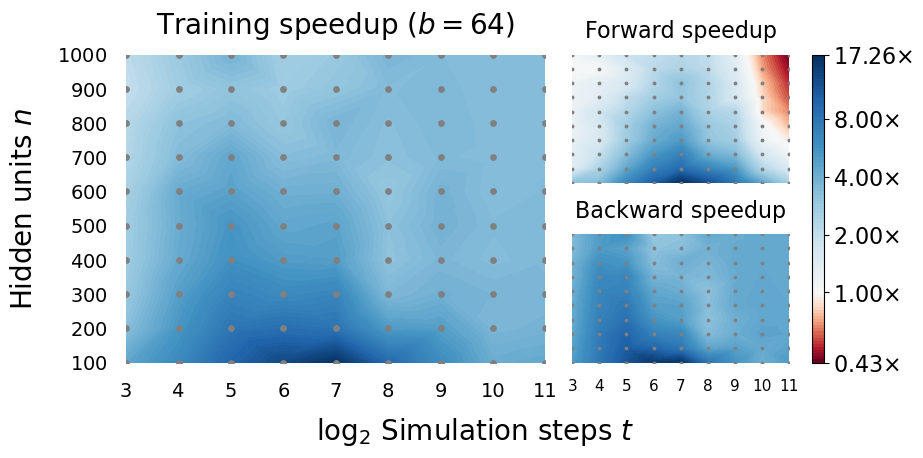

In [17]:
def plot_2d_speedups(fig, spec):
    
    def plot_2d_speedup(x, y, total_speedups, z_min, z_max, spec):
        ax = plt.Subplot(fig, spec)
        plot_contour(ax, x, y, total_speedups, z_min, z_max, ylabel="Number of units", title="Training speedup ($b=64$)", s=15)
        fig.add_subplot(ax)
    
    def plot_2d_subspeedups(x, y, forward_speedups, backward_speedups, pass_speedups, z_min, z_max, spec):
        subspeedup_spec = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=spec, hspace=0.4)
        
        # 1. 
        ax = plt.Subplot(fig, subspeedup_spec[0, 0])
        plot_contour(ax, x, y, forward_speedups, z_min, z_max, fontscale=0.8, ylabel="", title="Forward speedup")
        # Disable x axis
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        fig.add_subplot(ax)
        
        # 2. 
        ax = plt.Subplot(fig, subspeedup_spec[1, 0])
        colorbar = plot_contour(ax, x, y, backward_speedups, z_min, z_max, fontscale=0.8, title="Backward speedup")
        ax.set_yticklabels([])
        fig.add_subplot(ax)
        
        return colorbar
    
    speedups_df = benchmark_query.get_speedups(apply_mean_time=True, batch=128, heterogeneous_beta=True, beta_requires_grad=beta_requires_grad)
    speedups_df = speedups_df.groupby(["units", "t_len"]).mean()
    multi_index = speedups_df.index
    x = [np.log2(index[1]) for index in multi_index]
    y = [index[0] for index in multi_index]
    forward_speedups = np.log2(speedups_df["forward_speedup"])
    backward_speedups = np.log2(speedups_df["backward_speedup"])
    total_speedups = np.log2(speedups_df["total_speedup"])
    pass_speedups = None
    
    acc_z_min = min([forward_speedups.min(), backward_speedups.min(), total_speedups.min()]) 
    acc_z_max = max([forward_speedups.max(), backward_speedups.max(), total_speedups.max()]) 
    
    print(f"acc_z_min {acc_z_min}")
    print(f"acc_z_max {acc_z_max}")
    
    c = max(abs(acc_z_min), acc_z_max)
    
    speedup_spec = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=spec, wspace=0.08, hspace=0.3, width_ratios=[1, 0.6])
    speedup_rigt_spec = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=speedup_spec[0, 1], wspace=0.2, hspace=0.3, width_ratios=[0.95, 0.05])
    
    # Plot shared y label
    label_size = 20
    ax = fig.add_subplot(speedup_spec[0, 0])
    ax.set_ylabel("Hidden units $n$", fontsize=label_size, labelpad=60)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Plot shared x label
    label_size = 20
    ax = fig.add_subplot(speedup_spec[0, :])
    ax.set_xlabel("$\\log_2$ Simulation steps $t$", fontsize=label_size, labelpad=35)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Plot data
    plot_2d_speedup(x, y, total_speedups, acc_z_min, acc_z_max, speedup_spec[0, 0])
    colorbar = plot_2d_subspeedups(x, y, forward_speedups, backward_speedups, pass_speedups, acc_z_min, acc_z_max, speedup_rigt_spec[0, 0])
    
    # Plot colorbar
    cbar_ax = plt.Subplot(fig, speedup_rigt_spec[0, 1])
    fig.add_subplot(cbar_ax)
    cbar = fig.colorbar(colorbar, cbar_ax)
    
    cbarsize = 16
    cbarticksize = 16 #10
    cbartitle = "Speedup $\\times$"
    cbar = fig.colorbar(colorbar, cbar_ax)
    
    show_lower = False
    show_upper = False
    ticks = list(range(math.ceil(acc_z_min) + (0 if show_lower else 1), math.floor(acc_z_max) + (1 if show_upper else 0)))
    ticks = [acc_z_min, *ticks, acc_z_max]
    
    #ticks = [z_min, 0, z_max]
    tick_labels = [2 ** e for e in ticks]
    
    cbar.set_ticks(ticks)
    
    cbar.set_ticklabels([f'{v:0.2f}$\\times$' for v in tick_labels])
    cbar.ax.get_yaxis().labelpad = 10
    # cbar.ax.set_ylabel(cbartitle, fontsize=cbarsize)
    cbar.ax.tick_params(labelsize=cbarticksize)
    
fig = plt.figure(figsize=(9, 4))
fig_spec = gridspec.GridSpec(1, 1)
plot_2d_speedups(fig, fig_spec[0, 0])

## Plot duration

In [18]:
def plot(ax, xlabel, ylabel, title, pad=17):
    title_size = 20
    label_size = 20
    line_width = 3
    edge_width = 3
    errwidth = 2
    
    ax.tick_params(axis='both', which='major', pad=5, labelsize=label_size) 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(title, fontsize=title_size, pad=pad)
    
    # x-axis
    ax.spines["bottom"].set_linewidth(edge_width)
    ax.xaxis.set_tick_params(width=edge_width)
    ax.set_xlabel(xlabel, fontsize=label_size)
    
    # y-axis
    ax.spines["left"].set_linewidth(edge_width)
    ax.yaxis.set_tick_params(width=edge_width)
    ax.set_ylabel(ylabel, fontsize=label_size)
    
    ax.tick_params(axis='both', which='major', labelsize=16, pad=10)
    
    return ax

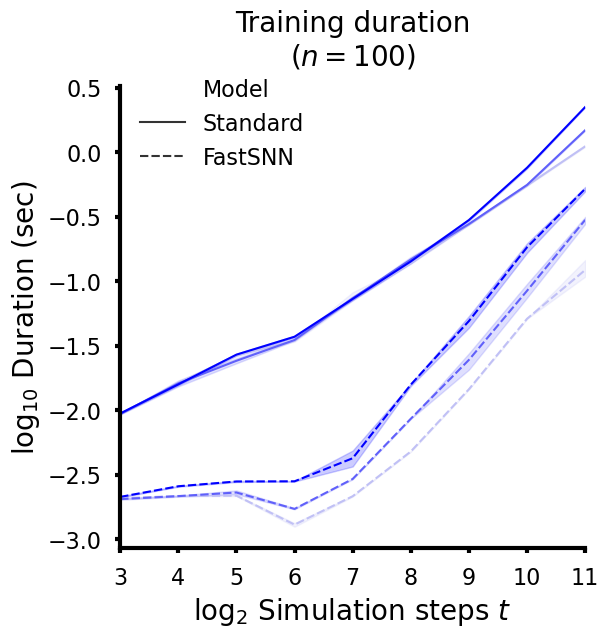

In [19]:
def plot_durations(durations_df, fig, spec):
    ax = plt.Subplot(fig, spec)
    fig.add_subplot(ax)
    plot(ax, "$\\log_2$ Simulation steps $t$", "$\\log_{10}$ Duration (sec)", "Training duration\n($n=100$)", 15)
    sns.lineplot(data=durations_df, x="t_len", y="total_time", hue="Batch", style="Model", palette=palette, ax=ax)
    ax.margins(x=0)
    ax.set_xscale("log")
    ax.set_xticks([8, 16, 32, 64, 128, 256, 512, 1024, 2048])
    ax.set_xticklabels([3, 4, 5, 6, 7, 8, 9, 10, 11])
    ax.get_xaxis().set_tick_params(which='minor', size=0)
    ax.get_xaxis().set_tick_params(which='minor', width=0) 
    current_handles, current_labels = ax.get_legend_handles_labels()
    for i in range(4):
        del current_handles[0]
        del current_labels[0]
    ax.legend(current_handles, current_labels, loc="upper left", fontsize=16, title_fontsize=16, frameon=False, bbox_to_anchor=(0, 1.06))
    
durations_df = benchmark_query.get_durations(units=100, heterogeneous_beta=True, beta_requires_grad=beta_requires_grad)
    
fig = plt.figure(figsize=(6, 6))
fig_spec = gridspec.GridSpec(1, 1, hspace=0.1, wspace=0.1)
plot_durations(durations_df, fig, fig_spec[0, 0])

# 2. Applicability to larger networks

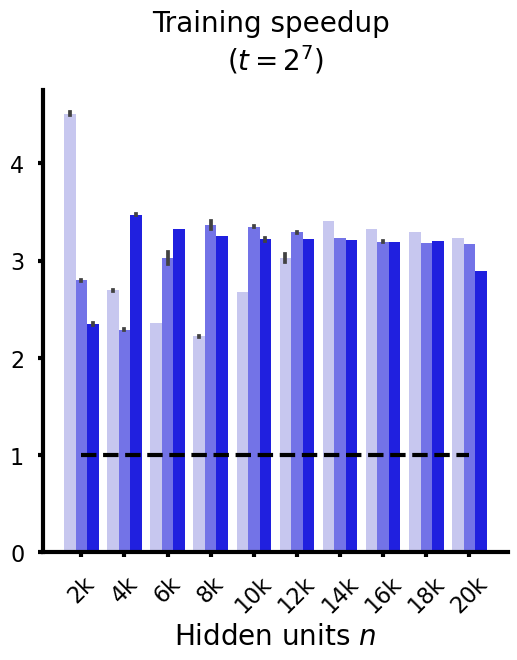

In [20]:
def plot_unit_speedups(unit_speedups_df, fig, spec):
    ax = plt.Subplot(fig, spec)
    fig.add_subplot(ax)
    sns.barplot(data=unit_speedups_df, x="units", y="total_speedup", hue="batch", palette=palette, ax=ax)
    plot(ax, "Hidden units $n$", "", "Training speedup \n($t=2^7$)", 15)
    ax.set_xticklabels(["2k", "4k", "6k", "8k", "10k", "12k", "14k", "16k", "18k", "20k"], rotation=45, size=16)
    ax.legend().set_visible(False)
    ax.plot([0, 9], [1, 1], linewidth=3, c="black", linestyle="--")
    
unit_speedups_df = benchmark_units_query.get_speedups(heterogeneous_beta=True, beta_requires_grad=beta_requires_grad).reset_index()
    
fig = plt.figure(figsize=(6, 6))
fig_spec = gridspec.GridSpec(1, 1, hspace=0.1, wspace=0.1)
plot_unit_speedups(unit_speedups_df, fig, fig_spec[0, 0])

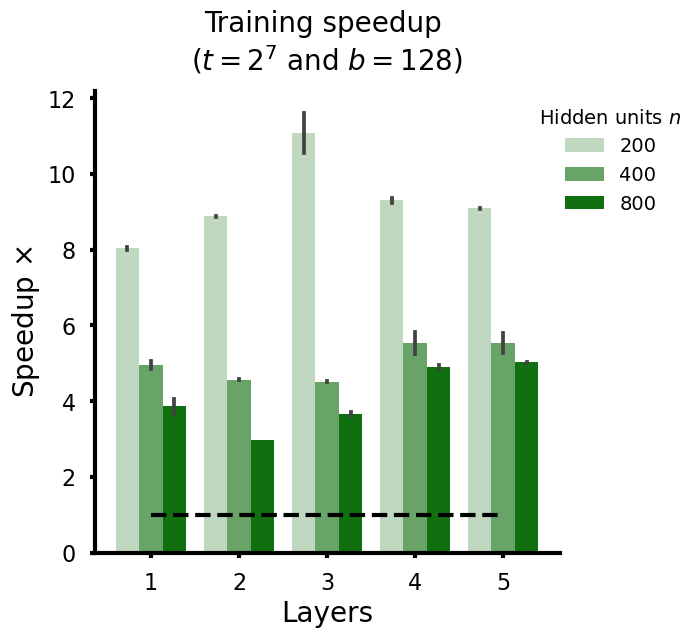

In [21]:
def plot_layer_speedups(layer_speedups_df, fig, spec):
    ax = plt.Subplot(fig, spec)
    fig.add_subplot(ax)
    palette = [sns.color_palette("light:g", as_cmap=False)[i] for i in [1, 3, 5]]
    sns.barplot(data=layer_speedups_df, x="layers", y="total_speedup", hue="units", palette=palette, ax=ax)
    plot(ax, "Layers", "Speedup $\\times$", "Training speedup \n($t=2^7$ and $b=128$)", 15)
    ax.legend(loc="upper right", title="Hidden units $n$", fontsize=14, title_fontsize=14, frameon=False, bbox_to_anchor=(1.3, 1))
    ax.plot([0, 4], [1, 1], linewidth=3, c="black", linestyle="--")
    
layer_speedups_df = benchmark_layers_query.get_speedups(heterogeneous_beta=True, beta_requires_grad=beta_requires_grad, batch=128).reset_index()
layer_query = layer_speedups_df["units"].isin([200, 400, 800])
layer_speedups_df = layer_speedups_df[layer_query]

fig = plt.figure(figsize=(6, 6))
fig_spec = gridspec.GridSpec(1, 1, hspace=0.1, wspace=0.1)
plot_layer_speedups(layer_speedups_df, fig, fig_spec[0, 0])

# 3. Speedup advantages over prior work and limitations

## Plot forward speedup

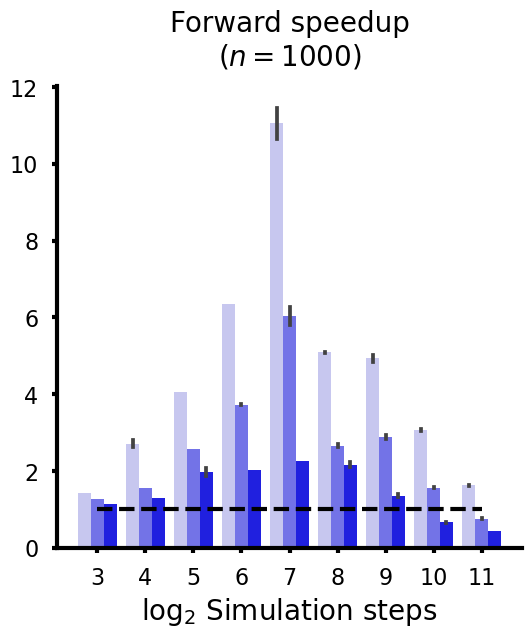

In [22]:
def plot_forward_speedups(speedups_df, fig, spec):
    ax = plt.Subplot(fig, spec)
    fig.add_subplot(ax)
    sns.barplot(data=speedups_df, x="t_len", y="forward_speedup", hue="batch", palette=palette, ax=ax)
    plot(ax, "$\\log_2$ Simulation steps", None, "Forward speedup\n($n=1000$)", 15)
    ax.set_xticklabels([3, 4, 5, 6, 7, 8, 9, 10, 11])
    ax.legend().set_visible(False)
    ax.plot([0, 8], [1, 1], linewidth=3, c="black", linestyle="--")
    
speedups_df = benchmark_query.get_speedups(units=1000, heterogeneous_beta=True, beta_requires_grad=beta_requires_grad).reset_index()
    
fig = plt.figure(figsize=(6, 6))
fig_spec = gridspec.GridSpec(1, 1, hspace=0.1, wspace=0.1)
plot_forward_speedups(speedups_df, fig, fig_spec[0, 0])

## Plot forward vs backward pass speedup

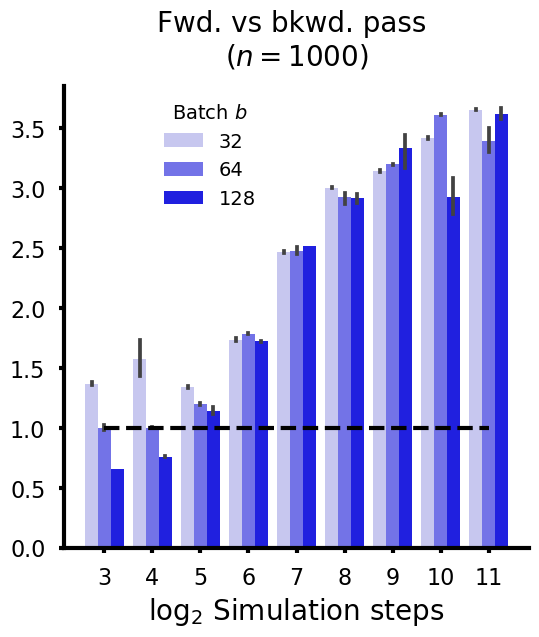

In [23]:
def plot_forward_vs_backward_speedup(forward_vs_backward_speedup_df, fig, spec):
    ax = plt.Subplot(fig, spec)
    fig.add_subplot(ax)
    sns.barplot(data=forward_vs_backward_speedup_df, x="t_len", y="relative_speedup", hue="Batch", palette=palette, ax=ax)
    plot(ax, "$\\log_2$ Simulation steps", None, "Fwd. vs bkwd. pass \n($n=1000$)", 15)
    ax.set_xticklabels([3, 4, 5, 6, 7, 8, 9, 10, 11])
    ax.legend(loc="upper right", title="Batch $b$", fontsize=14, title_fontsize=14, frameon=False, bbox_to_anchor=(0.45, 1))
    ax.plot([0, 8], [1, 1], linewidth=3, c="black", linestyle="--")
    
forward_vs_backward_speedup_df = benchmark_query.get_forward_vs_backward_speedup(units=1000, heterogeneous_beta=True, beta_requires_grad=beta_requires_grad)
        
fig = plt.figure(figsize=(6, 6))
fig_spec = gridspec.GridSpec(1, 1, hspace=0.1, wspace=0.1)
plot_forward_vs_backward_speedup(forward_vs_backward_speedup_df, fig, fig_spec[0, 0])

## Omnipotent plot

In [24]:
def plot_letter(letter, fig_spec, scale=1):
    shift = 0.2
    fontsize = 25
    ax = plt.Subplot(fig, fig_spec)
    ax.text(-shift/scale, 1.2, letter, horizontalalignment="right", verticalalignment="top", transform=ax.transData, fontweight="bold", fontsize=fontsize)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.patch.set_alpha(0)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    fig.add_subplot(ax)

acc_z_min -1.2104901803863486
acc_z_max 4.108999088991827


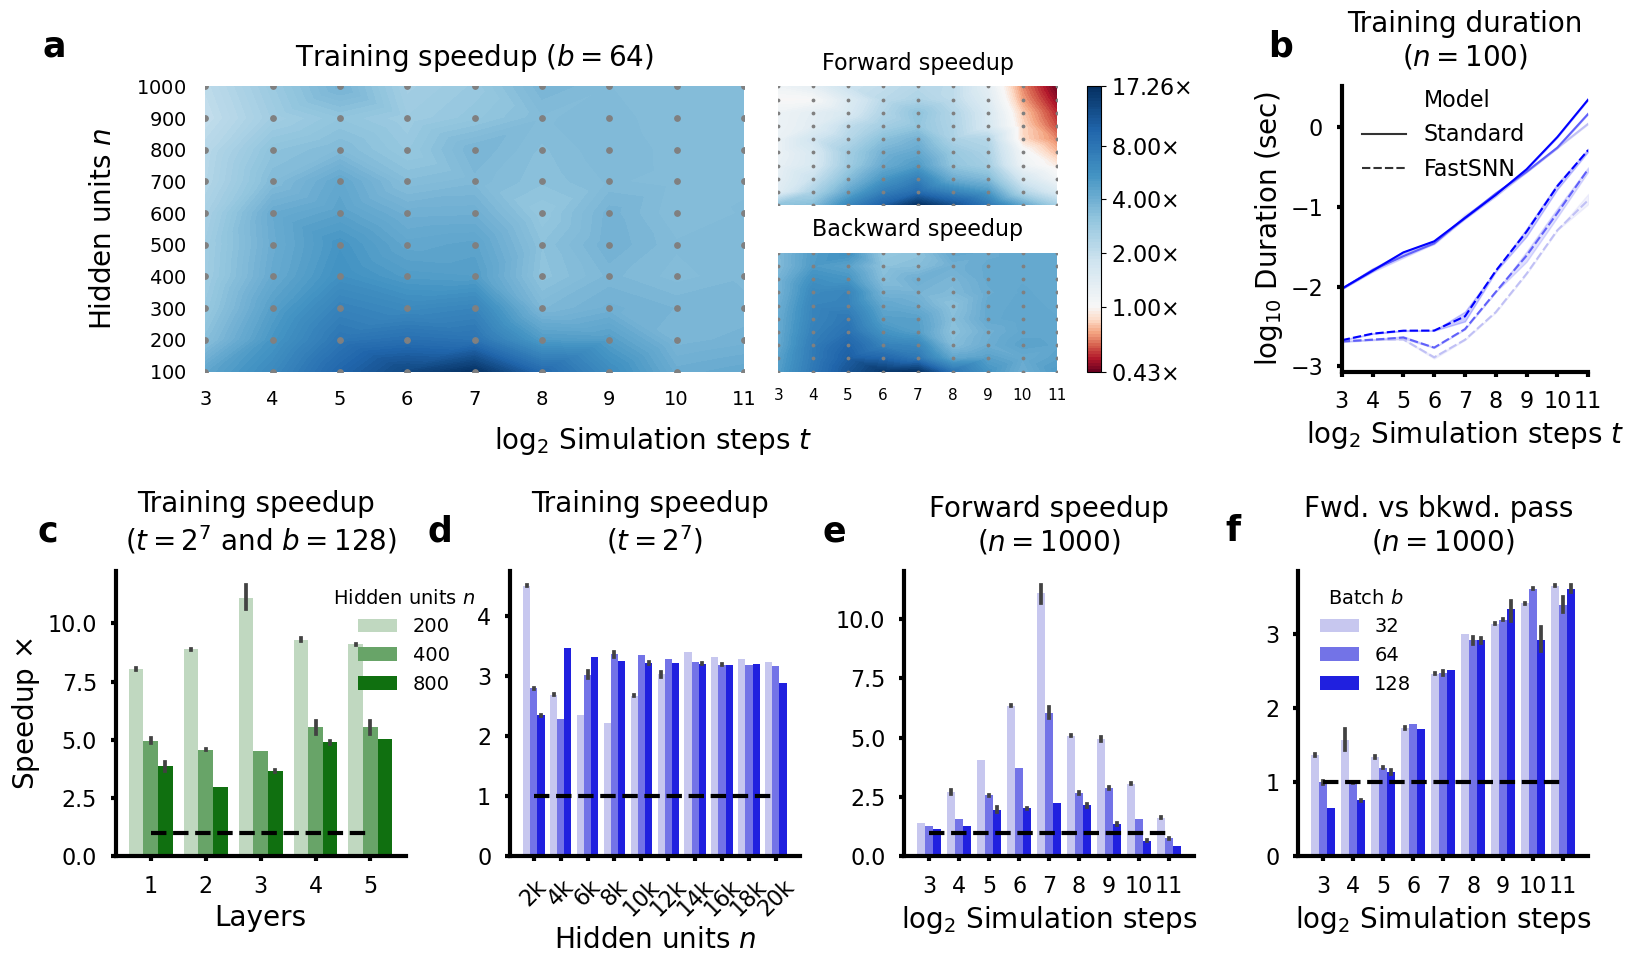

In [28]:
space = 0.65
fig = plt.figure(figsize=(19, 10))
fig_spec = gridspec.GridSpec(2, 1, hspace=0.7)

# Plot top row
top_spec = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=fig_spec[0, :], wspace=0.6*space, width_ratios=[1, 0.25])
pad_top_spec = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=top_spec[0, 0], width_ratios=[0.00, 1])
plot_2d_speedups(fig, pad_top_spec[0, 1])
plot_durations(durations_df, fig, top_spec[0, 1])

# Plot bottom row
bottom_spec = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=fig_spec[1, :], wspace=0.36)
plot_layer_speedups(layer_speedups_df, fig, bottom_spec[0, 0])
plot_unit_speedups(unit_speedups_df, fig, bottom_spec[0, 1])
plot_forward_speedups(speedups_df, fig, bottom_spec[0, 2])
plot_forward_vs_backward_speedup(forward_vs_backward_speedup_df, fig, bottom_spec[0, 3])

plot_letter("a", top_spec[0, 0], scale=4)
plot_letter("b", top_spec[0, 1])
plot_letter("c", bottom_spec[0, 0])
plot_letter("d", bottom_spec[0, 1])
plot_letter("e", bottom_spec[0, 2])
plot_letter("f", bottom_spec[0, 3])
plt.savefig(f"{root}/figures/figure3.pdf", dpi=300, bbox_inches="tight")